## Image processing

In previous examples we just use tensorflow MNIST module, so we don't have to worry about how to implement next_batch or how to load images and labels etc.. Of course tensorflow provide some API that load other dataset such as CIFAR-10, FLOWER...<br>
But sometimes (or usually) we need to train network using other dataset. In that case we have to build our custom dataset library or function.

In this notebook I'll give some wrapper function that,

1. Load images using path or url.
2. How to preprocess images.
3. How to generate next batch.

## Load images

In python, there are image processing libraries such as PIL(Python Image Library?), scikit-image or you can use Caffe library that generally used in deep learning. But I prefer scikit-image (also inside pyCaffe that python wrapper of Caffe use scikit-image), so in this notebook I'll explain using scikit-image (a.k.a skimage)

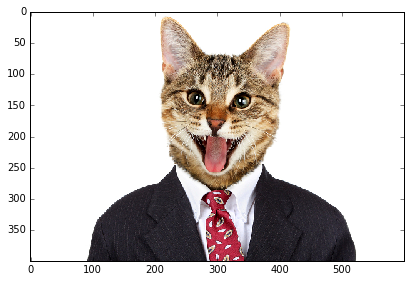

In [1]:
import skimage.io
import numpy as np
%matplotlib inline

# actually this function is based on caffe.io :)
def load_image(filename, color=True):
    
    img = skimage.img_as_float(skimage.io.imread(filename, 
        as_grey=not color)).astype(np.float32)
    # in case image is grey-scale
    if img.ndim == 2:
        img = img[:, :, np.newaxis]
        # if color
        # then convert grey-scale into RGB scale
        if color:
            img = np.tile(img, (1, 1, 3))
    # in case image channels are RGBA, ignore A(transparency)
    elif img.shape[2] == 4:
        img = img[:, :, :3]
    return img

im = load_image("../assets/cat.jpg")
skimage.io.imshow(im)

## Preprocess images - 1

If you input images into CNN or NN, input size(height, width) must be same. So we have to resize images. Also we can easily do this process using skimage.<br>
Umm.. also this code is from `caffe.io` so if you dont understand how this works, just use it! But basic idea is simple. there is a function `skimage.transform.resize` and we just call this function. But in `caffe.io` to handle exceptions code is little bit complicated.

In [2]:
from skimage.transform import resize

def resize_image(im, new_dims, interp_order=1):

    if im.shape[-1] == 1 or im.shape[-1] == 3:
        im_min, im_max = im.min(), im.max()
        if im_max > im_min:
            # skimage is fast but only understands {1,3} channel images
            # in [0, 1].
            im_std = (im - im_min) / (im_max - im_min)
            resized_std = resize(im_std, new_dims, order=interp_order)
            resized_im = resized_std * (im_max - im_min) + im_min
        else:
            # the image is a constant -- avoid divide by 0
            ret = np.empty((new_dims[0], new_dims[1], im.shape[-1]),
                           dtype=np.float32)
            ret.fill(im_min)
            return ret
    else:
        # ndimage interpolates anything but more slowly.
        scale = tuple(np.array(new_dims, dtype=float) / np.array(im.shape[:2]))
        resized_im = zoom(im, scale + (1,), order=interp_order)
    return resized_im.astype(np.float32)

im = load_image("../assets/cat.jpg")
print(im.shape)
im = resize_image(im, (256, 256))
print(im.shape)

(400, 600, 3)
(256, 256, 3)


## Preprocess images - 2

If you use pre-trained network, you must normalize images. If not performance is very worse. Idea is simple, some researchers get average channel values using imagenet training dataset(maybe almost 1M images), so we just sub each channel using average channel value.

Below function `load_and_preprocess_image` does entire basic preprocessing that resizing image using `resize_side` args, and substract with `MEAN_VALUE`. Note that `MEAN_VALUE[0]` is R channel, `MEAN_VALUE[1]` is G and `MEAN_VALUE[2]` is B channel.

Also note that when we load images using `skimage.io.imread`, range of pixel value is [0, 1). But most of pre-trained network assume input range is [0, 255) so we have to rescale pixel range by multiply 255 in all images.

In [3]:
def load_and_preprocess_image( path, 
                               resize_dim=None ):
    
    MEAN_VALUE = np.array([123.68, 116.779, 103.939])

    im = load_image(path)
    if not resize_dim is None:
        im = resize_image(im, resize_dim)
    
    im *= 255
    im -= MEAN_VALUE

    return im

im = load_image("../assets/cat.jpg")
print(np.mean(im, axis=(0, 1))*255)
im = load_and_preprocess_image("../assets/cat.jpg")
print(np.mean(im, axis=(0, 1)))

[ 204.70292664  197.27879333  194.58753967]
[ 81.05184174  80.3614502   90.82659912]


## BGR? RGB?

**REALLY IMPORTANT** most of pre-trained model is based on `Caffe`, and Caffe (not pyCaffe) use OpenCV when load and preprocess image. AND **OPENCV USE BGR CHANNEL**. BUT, skimage use RGB Channel so you have to swap axis when you use caffe version of pre-trained model, just like below code (this is naive version).

```python
# convert RGB -> BGR (caffe use openCV and openCV use BGR default)
bgr = np.empty((3, height, width))
bgr[0] = img[2]
bgr[1] = img[1]
bgr[2] = img[0]
```

But I don't know why, when you use tensorflow-silm pre-trained model, this model use RGB channel not BGR. So in most case you use BGR, but when you use tensorflow-slim pre-trained model just use RGB.

## Generate batch data

There are plenty of method about it, but below code is part of my code that I usually use. 

In [4]:
def next_batch( data,
                indices, 
                resize_dim=None):
    """
    Args
      data: python list type that contain image path (or url).
            e.g. [image_path1, image_path2 ...]
      indices: numpy array that contain indices of next batch
               when we have to randomly select batch, indices must be choosen randomly,
               but in case select sequentially, vice versa.
      resize_dim: image size. must be [H, W] shape. image resize using resize_dim args.
    """
    
    bimg = np.empty((len(indices), resize_dim[0], resize_dim[1], 3))
    for i, index in enumerate(indices):
        bimg[i] = load_and_preprocess_image(data[index], resize_dim)

    return bimg

data = ["../assets/cat.jpg", "../assets/cat.jpg", "../assets/graph.png"]
indices = np.array([0, 2]) # or randomly selected using numpy. google it!
batch = next_batch(data, indices, (224, 224))

print(batch.shape)

(2, 224, 224, 3)


In this `next_batch` function, I only return `batch_image` but in many case label information also needed.<br>
In that case just modify this function to return label too. It's up to you.<br>